In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../..'))) # access sibling directories
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

from src.python.settings import summary_meta_diffusion, probability_meta_diffusion
from src.python.helpers import load_empirical_rt_data, join_and_fill_missings
from src.python.helpers import inspect_robustness_noise, inspect_robustness_bootstrap, inspect_robustness_lopo
from src.python.losses import softmax_loss
from src.python.networks import HierarchicalInvariantNetwork, ModelProbabilityNetwork
from src.python.visualization import plot_model_posteriors, plot_noise_robustness

import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.facecolor'] = 'w'

from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer

In [2]:
# Hack to correctly set facecolor to white
# matplotlib 3.5 only sets facecolor if a plot was already created 
_ = plt.figure()
plt.rcParams['figure.facecolor'] = 'w'

<Figure size 432x288 with 0 Axes>

# Application to empirical data

## Load in data

In [3]:
# Load data from folders

parent_folder = os.path.dirname(os.path.dirname(os.getcwd()))
color_folder = os.path.join(parent_folder, 'data\\03_levy_flight_application\\data_rts\\color')
lexical_folder = os.path.join(parent_folder, 'data\\03_levy_flight_application\\data_rts\\lexical')

color_data = load_empirical_rt_data(color_folder)
lexical_data = load_empirical_rt_data(lexical_folder)

# Join experimental data and fill missing values
empirical_data = join_and_fill_missings(color_data, lexical_data, n_trials=900, missing_rts_equal_mean=True)

## Load in trained network

In [4]:
summary_net = HierarchicalInvariantNetwork(summary_meta_diffusion)
probability_net = ModelProbabilityNetwork(probability_meta_diffusion)
amortizer = MultiModelAmortizer(probability_net, summary_net)

# Checkpoint path for loading pretrained network and saving the final network
checkpoint_path = "c:\\Users\\lasse\\documents\\hierarchical_model_comparison_project\\checkpoints\\03_levy_flight_application\\truncnormal_alpha_prior\\fine-tuned_net"

trainer = ModelComparisonTrainer(
    network=amortizer, 
    loss=partial(softmax_loss),
    optimizer=partial(Adam),
    checkpoint_path=checkpoint_path,
    skip_checks=True
    )

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from c:\Users\lasse\documents\hierarchical_model_comparison_project\checkpoints\03_levy_flight_application\truncnormal_alpha_prior\fine-tuned_net\ckpt-50


## Predict

In [5]:
preds = probability_net.predict(summary_net(empirical_data))
preds

{'m_probs': array([[0.00000014, 0.00026828, 0.02859666, 0.9711349 ]], dtype=float32)}

In [6]:
labels_verbose = ['Basic diffusion model',
                  'Basic Lévy flight model',
                  'Full diffusion model',
                  'Full Lévy flight model']

labels = ['$\mathcal{M}_1$',
          '$\mathcal{M}_2$',
          '$\mathcal{M}_3$',
          '$\mathcal{M}_4$']

### Plot model posteriors

In [7]:
# Get samples from dirichlet distribution
#dirichlet = probability_net.sample(summary_net(empirical_data),100000)
#dirichlet_flat = np.squeeze(dirichlet)

In [8]:
# Plot model posterior 
#plot_model_posteriors(dirichlet_samples=dirichlet, labels=labels, save=True)

### Get PMP & BF tables

In [96]:
# Get posterior model probabilities

pmp_table = pd.DataFrame(preds['m_probs'], index=['$\text{PMP}$'], columns=labels)
pmp_table

,$\mathcal{M}_1$,$\mathcal{M}_2$,$\mathcal{M}_3$,$\mathcal{M}_4$
$PMP$,1.417793e-07,0.000268,0.028597,0.971135


In [97]:
# Get 95% credible interval for posterior model probabilities
#cred_pmps = np.quantile(dirichlet_flat, [0.025, 0.975], axis=0).round(2)
#cred_pmps

In [98]:
# Get Bayes Factors

bfs = []

for model in range(4):
    for model_prob in preds['m_probs']:
        model_bfs = model_prob/preds['m_probs'][0][model]
        #bfs.append(model_bfs.round(2))
        bfs.append(model_bfs)

bf_table_all = pd.DataFrame(bfs, index=labels_verbose, columns=labels_verbose)
bf_table_all

,Basic diffusion model,Basic Lévy flight model,Full diffusion model,Full Lévy flight model
Basic diffusion model,1.000000e+00,1892.249390,201698.359375,6.849622e+06
Basic Lévy flight model,5.284715e-04,1.000000,106.591843,3.619831e+03
Full diffusion model,4.957898e-06,0.009382,1.000000,3.395973e+01
Full Lévy flight model,1.459935e-07,0.000276,0.029447,1.000000e+00


In [99]:
# Select Bayes Factors for publication

bfs_contra = pd.DataFrame(bf_table_all.iloc[3, :].values.reshape(1, 4), index=['$\text{BF}_{j4}$'], columns=labels)
bfs_contra

,$\mathcal{M}_1$,$\mathcal{M}_2$,$\mathcal{M}_3$,$\mathcal{M}_4$
$BF_{j4}$,1.459935e-07,0.000276,0.029447,1.0


In [100]:
bfs_pro = pd.DataFrame(bf_table_all.iloc[:, 3].values.reshape(1, 4), index=['$\text{BF}_{4j}$'], columns=labels)
bfs_pro

,$\mathcal{M}_1$,$\mathcal{M}_2$,$\mathcal{M}_3$,$\mathcal{M}_4$
$BF_{4j}$,6849622.0,3619.830566,33.959732,1.0


In [101]:
# # Get 95% credible interval for Bayes factors
# dirichlet_pref_model = np.reshape(np.repeat(dirichlet_flat[:,3], 4), (100000, 4))
# dirichlet_bfs = dirichlet_flat/dirichlet_pref_model
# cred_bfs = np.quantile(dirichlet_bfs, [0.025, 0.975], axis=0).round(2)
# cred_bfs

In [102]:
# # Create table for publication

# # Insert credible intervals
# for m in range(4):
#     bf_table.iloc[0, m] = f'{bf_table.iloc[0, m]:.3}' + f' ({cred_bfs[0][m]}--{cred_bfs[1][m]})' 
#     # :.3 to prevent unrounding of BFs
#     pmp_table.iloc[0, m] = f'{pmp_table.iloc[0, m]:.2}' + f' ({cred_pmps[0][m]}--{cred_pmps[1][m]})' 
    
# bf_table.iloc[0, 3] = '*' # replace 1s of preferred model
# results_table = pd.concat([bf_table, pmp_table])
# results_table

In [103]:
# Get LaTeX table for publication
#print(results_table.style.to_latex(position='h', position_float='centering', hrules=True))

In [104]:
# Create table for publication WITHOUT UNCERTAINTIES

for m in range(4):
    if bfs_contra.iloc[0, m] < 0.01: # only resort to scientific notation when needed
        bfs_contra.iloc[0, m] = f'{bfs_contra.iloc[0, m]:.2e}'
    else:
        bfs_contra.iloc[0, m] = bfs_contra.iloc[0, m].round(2)

    if bfs_pro.iloc[0, m] > 1000: # only resort to scientific notation when needed
        bfs_pro.iloc[0, m] = f'{bfs_pro.iloc[0, m]:.2e}'
    else:
        bfs_pro.iloc[0, m] = bfs_pro.iloc[0, m].round(2)

    if pmp_table.iloc[0, m] < 0.01:
        pmp_table.iloc[0, m] = f'{pmp_table.iloc[0, m]:.2e}'
    else:
        pmp_table.iloc[0, m] = pmp_table.iloc[0, m].round(2)

bfs_contra.iloc[0, 3] = '*' # replace 1s of preferred model
bfs_pro.iloc[0, 3] = '*' # replace 1s of preferred model
results_table = pd.concat([bfs_contra, bfs_pro, pmp_table])
results_table

,$\mathcal{M}_1$,$\mathcal{M}_2$,$\mathcal{M}_3$,$\mathcal{M}_4$
$BF_{j4}$,1.46e-07,2.76e-04,0.030000,*
$BF_{4j}$,6.85e+06,3.62e+03,33.959999,*
$PMP$,1.42e-07,2.68e-04,0.030000,0.97


In [93]:
print(results_table.style.to_latex(position='h', position_float='centering', hrules=True))

\begin{table}[h]
\centering
\begin{tabular}{lllrl}
\toprule
 & $\mathcal{M}_1$ & $\mathcal{M}_2$ & $\mathcal{M}_3$ & $\mathcal{M}_4$ \\
\midrule
$BF_{j4}$ & 1.46e-07 & 2.76e-04 & 0.030000 & * \\
$BF_{4j}$ & 6.85e+06 & 3.62e+03 & 33.959999 & * \\
$PMP$ & 1.42e-07 & 2.68e-04 & 0.030000 & 0.970000 \\
\bottomrule
\end{tabular}
\end{table}



# Robustness checks

## Results under data perturbations

In [7]:
bootstrapped_trials = inspect_robustness_bootstrap(empirical_data, probability_net, summary_net, level='trials', n_bootstrap=100)
bootstrapped_participants = inspect_robustness_bootstrap(empirical_data, probability_net, summary_net, level='participants', n_bootstrap=100)
leave_one_participant_out = inspect_robustness_lopo(empirical_data, probability_net, summary_net)

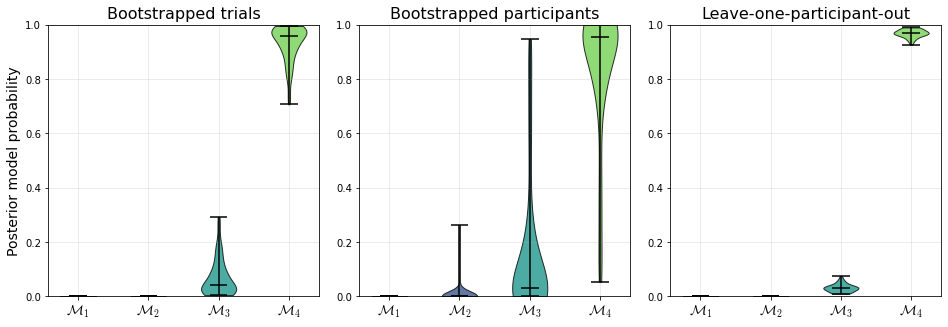

In [8]:
fig, axarr = plt.subplots(1, 3, figsize=(16, 5))
plt.subplots_adjust(wspace=0.15)

plot_model_posteriors(bootstrapped_trials, labels, title='Bootstrapped trials', ax=axarr[0])
plot_model_posteriors(bootstrapped_participants, labels, ylabel=False, title='Bootstrapped participants',ax=axarr[1])
plot_model_posteriors(leave_one_participant_out, labels, ylabel=False,  title='Leave-one-participant-out',ax=axarr[2])

plt.savefig('levy_perturbation_robustness.pdf', dpi=300, bbox_inches='tight')

## Results under additional noise

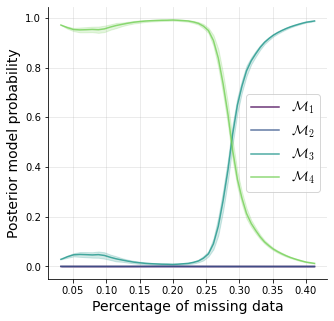

In [7]:
added_noise_percentages = np.arange(0, 0.51, 0.01)
mean_noise_proportion_list, mean_probs, mean_sds = inspect_robustness_noise(added_noise_percentages, 
                                                                                       empirical_data, probability_net, 
                                                                                       summary_net, n_runs=100)

plot_noise_robustness(mean_noise_proportion_list, mean_probs, mean_sds, labels, save=True)